# Big Data Analytics - Pokemon API

## Introduction

The idea behind this project is to practice some of the techniques and topics learnt on the BDA subject. We had the freedom of choosing any topic that we desired, in this case the topic choosen is Pokemon Data Analysis. While it can be argued that this topic might not provide much value itself we can say for sure that it serves as an extremelly good playground for data analysis practice. This is due to the nature of the Pokemon game series in which there are a lot of stats and data surrounding all of the creatures and the world they live in. It can also be interesting to see how such a relevant comercial product might have evolved in order to adapt to recent times. The final reason that made this project a good option is how easily to access and use the PokéAPI proved to be, it also does not have any usage quotas as long as you make a fair use of it.


## Data Gathering

All of the data used for this project has ben obtained from the PokéAPI https://pokeapi.co/ which is an open and free api containing all sorts of data related to the pokemon videogame series. All of the data has been gathered using REST calls self contained on a script that takes care of the database population task. In this specific case, the database is a simple MongoDB setup hosted on a local machine since it was more than enough for this project. All of the data gathering has been made on python with the help of the requests and pymongo libraries. Some adaptations have been made from the original json structure in order to facilitate the data analysis. These include moving stats and types into basic variables, removing unused atributes and simplifying attributes with redundant data like species only keeping the name.

In order to see the docs of the api used you can go to: https://pokeapi.co/docs/v2

## Data Preprocessing

Some data processing has been made when gathering the data to have documents that are easier to analyze, here the code used to transform each json response from both the pokemon and pokemon-species endpoints responses can be seen:

```python
# Process Pokemon Collection
# Remove fields that wont be used for sure
del data['sprites']
del data['location_area_encounters']
# We only keep species name
data['species'] = data['species']['name']
# Types and stats are allways the same amount so change how they are stored to keep it simpler
del data['types']
del data['stats']
stats = {stat['stat']['name']: stat['base_stat'] for stat in res_data['stats']}

if len(res_data['types']) > 1:
    types = {
        'type1': res_data['types'][0]['type']['name'],
        'type2': res_data['types'][1]['type']['name']
    }
else:
    types = {
        'type1': res_data['types'][0]['type']['name'],
        'type2': None
    }      

# Merge all data
data.update(stats)
data.update(types)      
```
```python
# Process Pokemon-Species Collection
# Delete unwanted fields
        del data['egg_groups']
        del data['evolves_from_species']
        del data['flavor_text_entries']
        del data['form_descriptions']
        del data['genera']
        del data['growth_rate']
        del data['names']
        del data['pal_park_encounters']
        del data['pokedex_numbers']
        del data['varieties']
        del data['has_gender_differences']

        # Simplify some fields
        data['color'] = data['color']['name']        
        data['evolution_chain'] = data['evolution_chain']['url'].split('/')[-2]
        try:
            data['evolves_from'] = res_data['evolves_from_species']['name']
        except TypeError:
            data['evolves_from'] = None
        data['generation'] = data['generation']['name']
        try:
            data['habitat'] = data['habitat']['name']
        except TypeError:
            data['habitat'] = None
        data['gender_diff'] = res_data['has_gender_differences']
        data['shape'] = data['shape']['name']
```
There is missing data included on the type2 attribute, since many pokemon only have a single type assigned to them. However, this is expected and we just have to take into acount that there exist pokemon with a single type.

Some new fields can also be created during the analysis, it is also interesting to know which of the pokemon are legendary which is not included in the api data but can be obtained from other sources.

## Data Analysis
In this section a step by step exploratory data analysis will be performed following the code.

Firstly we make the necessary imports and write a small util to transform mongodb queries into dataframes.

In [16]:
import pymongo
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

# Mongo to dataframe utility
def query_df(collection, query={}, proj={}, no_id=True):
    cursor = collection.find(query, proj)
    df =  pd.DataFrame(list(cursor))
    if no_id:
        del df['_id']
    return df

# Function that displays a list dfs side by side
from IPython.display import display_html
def display_side_by_side(dfs):
    html_str=''
    for df in dfs:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

We then connect to the pokemon database.

In [2]:
# Connect to the db
db_name = 'pokebda'
client = pymongo.MongoClient('mongodb://localhost:27017/')
db = client[db_name]

After connecting to the database, go to the desired collection and make a simple query to get some basic information for all pokemon into a pandas dataframe.

In [24]:
# Load a projection of pokemon collection into a dataframe
pokemon = db['pokemon']

proj = {
    'name': 1,
    'species': 1,
    'height': 1,
    'weight': 1,
    'type1': 1,
    'type2': 1,
    'hp': 1,
    'attack': 1,
    'defense': 1,
    'special-attack': 1,
    'special-defense': 1,
    'speed': 1,
}
df = query_df(pokemon, {}, proj)
df.head()

,height,name,species,weight,hp,attack,defense,special-attack,special-defense,speed,type1,type2
0,7,bulbasaur,bulbasaur,69,45,49,49,65,65,45,grass,poison
1,10,ivysaur,ivysaur,130,60,62,63,80,80,60,grass,poison
2,20,venusaur,venusaur,1000,80,82,83,100,100,80,grass,poison
3,6,charmander,charmander,85,39,52,43,60,50,65,fire,None
4,11,charmeleon,charmeleon,190,58,64,58,80,65,80,fire,None


Look for missing data, missing data on type 2 is already expected.

In [25]:
df.isnull().sum()

height               0
name                 0
species              0
weight               0
hp                   0
attack               0
defense              0
special-attack       0
special-defense      0
speed                0
type1                0
type2              456
dtype: int64

Luckily no missing data is found on any of the choosen fields except the one already expected. Out of the 898 known existing pokemon 456 dont have two types, that is roughly a 50% of the cases. Lets do the same for the pokemon species collection.

In [27]:
# Load a projection pokemon-species collection into a dataframe
species = db['species']

proj = {
    'capture_rate': 1,
    'color': 1,
    'evolution_chain': 1,
    'formw_switchable': 1,
    'gender_rate': 1,
    'generation': 1,
    'habitat': 1,
    'is_baby': 1,
    'is_legendary': 1,
    'is_mythical': 1,
    'name': 1,
    'shape': 1,
    'evolves_from': 1,
    'gender_diff': 1
}
df2 = query_df(species, {}, proj)
df2.head()

,capture_rate,color,evolution_chain,gender_rate,generation,habitat,is_baby,is_legendary,is_mythical,name,shape,evolves_from,gender_diff
0,45,green,1,1,generation-i,grassland,False,False,False,bulbasaur,quadruped,None,False
1,45,green,1,1,generation-i,grassland,False,False,False,ivysaur,quadruped,bulbasaur,False
2,45,green,1,1,generation-i,grassland,False,False,False,venusaur,quadruped,ivysaur,True
3,45,red,2,1,generation-i,mountain,False,False,False,charmander,upright,None,False
4,45,red,2,1,generation-i,mountain,False,False,False,charmeleon,upright,charmander,False


We also look for missing data here.

In [28]:
df2.isnull().sum()

capture_rate         0
color                0
evolution_chain      0
gender_rate          0
generation           0
habitat            512
is_baby              0
is_legendary         0
is_mythical          0
name                 0
shape                0
evolves_from       468
gender_diff          0
dtype: int64

We see that the fields habitat and evolves_from present missing data on nearly the 50% of cases. For the habitat attribute it represents that such pokemon cannot be found in the wild and has to be obtained by different means such as evolution. In the case of evolves_from we can have two situations, the first one is a pokemon that is the first of an evolution chain, the second is when a pokemon does not belong to an evolution chain. Note that even when it does not have an evolution chain id is still assigned to itself.

Now we can start analyzing some of the gathered data, a good starting point can be to look at the pokemon stats. Any pokemon has a list of six different stats, these stats have a base value which is fixed for each of them and influences their strenghts and weaknessess. This is the list of existing stats:
- **HP:** Stands for hit points, determines how much damage it can recieve before becoming debilitated.
- **Attack:** Determines how much damage it can do, it is computed with the enemy's defense.
- **Defense:** Determines how good is resisting normal attacks.
- **Special Attack:** Determines how much special damage it can do, it is computed with the enemy's special defense.
- **Special Defense:** Determines how good is resisting special attacks.
- **Speed:** Is an indicator of how fast it is and helps calculating who attacks first.

Lets make histograms for each of the stats that exist for any pokemon ever created. 

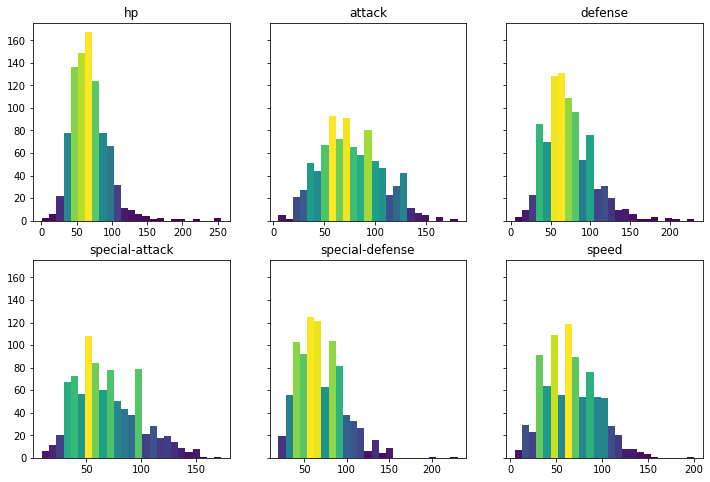

In [5]:
n_bins = 25
fig, axs = plt.subplots(2, 3, sharey=True, figsize=(12,8))

stats = ['hp', 'attack', 'defense', 'special-attack', 'special-defense', 'speed']
for ax, st in zip(axs.reshape(-1), stats):
    ax.set_title(st)
    N, bins, patches = ax.hist(df[st], bins=n_bins)
    fracs = N / N.max()
    norm = colors.Normalize(fracs.min(), fracs.max())
    for thisfrac, thispatch in zip(fracs, patches):
        color = plt.cm.viridis(norm(thisfrac))
        thispatch.set_facecolor(color)

We can see that all of the stats somewhat resemble a normal distribution with its mean arround 55, however some pretty big outliers can be seen on all of the plots. It can also be seen that standard deviation is much lower on the hp department and bigger on Attack Special Attack and Speed. Since we know that there are some outliers it can be interesting to see which are these specific cases for all categories, lets have a look by findig the top and bottom 5 for all stats.

In [17]:
stats = ['hp', 'attack', 'defense', 'special-attack', 'special-defense', 'speed']
dfs = []
for stat in stats:
   dfs.append(df.nlargest(5, stat)[['name', stat]])
display_side_by_side(dfs)
dfs = []
for stat in stats:
   dfs.append(df.nsmallest(5, stat)[['name', stat]])
display_side_by_side(dfs)

,name,hp
241,blissey,255
112,chansey,250
798,guzzlord,223
894,regidrago,200
201,wobbuffet,190
,name,attack
797,kartana,181
408,rampardos,165
288,slaking,160
485,regigigas,160


,name,hp
291,shedinja,1
49,diglett,10
128,magikarp,20
171,pichu,20
212,shuckle,20
,name,attack
112,chansey,5
439,happiny,5
128,magikarp,10
212,shuckle,10


By looking at all of these stats we can see various names that are repeated on multiple categories, some of the most noticeable ones in terms of multiple categoriesare Shuckle, Blissey, Chansey and magikarp. Lets have a brief look at all of them.

**Shuckle** is the best on defense and special defense with a value of 230, it also has the worst special attack and speeds. His attack value is also the 4th worst. With all of this we can see that this is an extremelly deffensive creature with virtually no attack capabilities.
<div>
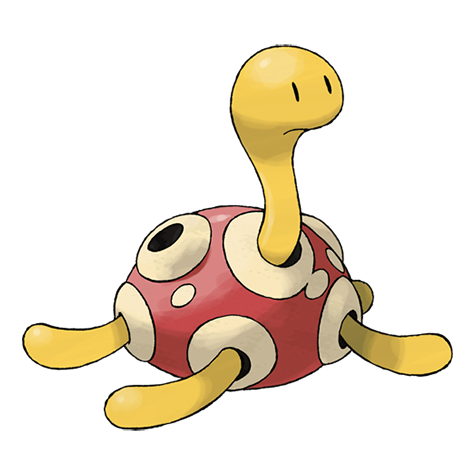
</div>

**Chansey & Blissey** are both pokemon from the same evolution line, whih means that chansey evolves into Blissey into certain conditions which can help explain why they have very similar stat distributions. They are also very defensive pokemon but they strengths differ from the previous case. In this case their deffensive strategy is based on having the biggest amount of Hit Points on the entire game, however we can see that they also have an extremelly low phisical defense which makes them vulnerable to this type of attack. Their special defense values are 105 and 135 which in combination with their high HP makes them excellent against this type of damage.
<div>
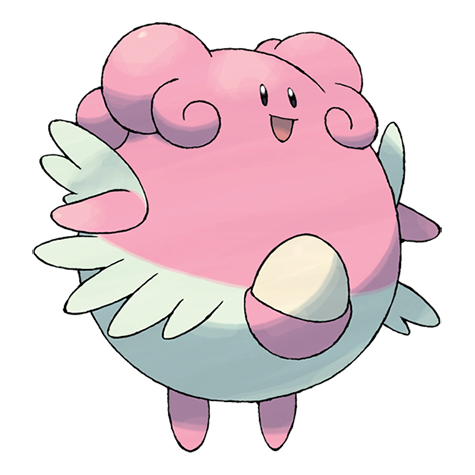
</div>
<div>
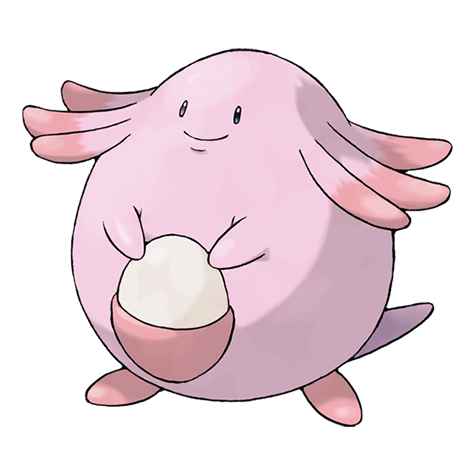
</div>

**Magikarp** is known to be one of the most useless creatures out of the 898 that do exist. This can be easily observed on the extracted data where it consistently appears on the top 5 worst for four different categories (hp, attack, special-attack, special-defense). This was expected since this innofensive fish looking pokemon was created with the intention of making it practically useless, however what makes it interesting is that it evolves into a very strong creature called Gyarados.
<div>
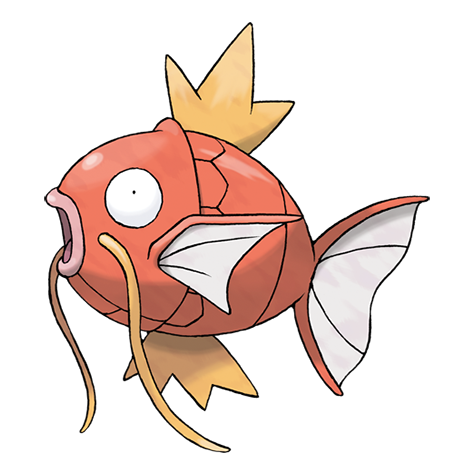
</div>

We now create a new attribute to evaluate total power to somewhat represent the combined amount of stats of each pokemon, however it is important to note that this does not directly correlate to a pokemon strength since it depends on the matchup and specialized stats can be situationally better in a lot of cases. We define this new attribute as power and compute it by summing the 6 base stats.

In [22]:
# Compute power attribute
df['power'] = df['hp'] + df['attack'] + df['defense'] + df['special-attack'] + df['special-defense'] + df['speed']

# See top 10 and bottom 10 in terms of power
top_power = df.nlargest(10, 'power')[['name', 'power']]
bottom_power = df.nsmallest(10, 'power')[['name', 'power']]
display_side_by_side([top_power, bottom_power])

,name,power
492,arceus,720
889,eternatus,690
149,mewtwo,680
248,lugia,680
249,ho-oh,680
383,rayquaza,680
482,dialga,680
483,palkia,680
486,giratina-altered,680
642,reshiram,680


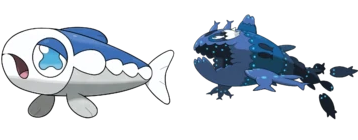
<div>
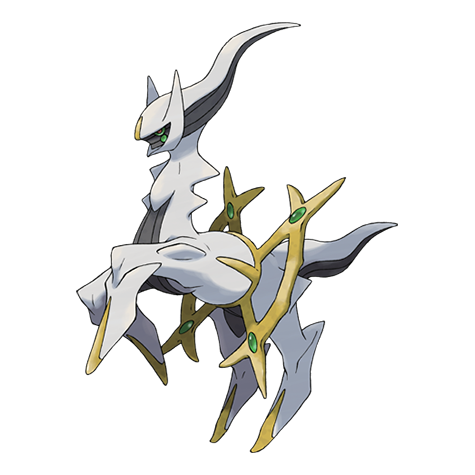
</div>